## import dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from gatspy import periodic

## global settings

In [2]:
mpl.style.use("dark_background")

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.linestyle"] = ":"

plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## load sunpot record & EXPRES-S values

In [3]:
SN_record = pd.read_csv("Data/SN_d_tot_V2.0.csv", delimiter=';')
SN_record.columns = ['year', 'month', 'day', 'yr_dec', 'SN', 'dev', 'obs', 'def']
SN_record.index = pd.to_datetime(SN_record[['year', 'month', 'day']], errors='ignore')
SN_record = pd.Series(SN_record['SN'])
SN_record[SN_record==-1] = np.nan

s_values_2020 = pd.read_pickle("Data/expres_s_2020.pickle")
s_values_2021 = pd.read_pickle("Data/expres_s_2021.pickle")
s_values_2022 = pd.read_pickle("Data/expres_s_2022.pickle")
s_values = pd.concat([s_values_2020, s_values_2021, s_values_2022])
s_values.index = pd.to_datetime(s_values.index, format="%y%m%d")

In [4]:
date_range = pd.date_range('2020-07', '2022-05')
SN_daily = SN_record.reindex(index=date_range)
s_values = s_values.reindex(index=date_range)

## statistics

In [5]:
SN_daily.describe()

count    669.000000
mean      32.503737
std       31.762574
min        0.000000
25%       11.000000
50%       23.000000
75%       47.000000
max      150.000000
Name: SN, dtype: float64

In [6]:
s_values.describe()

count    330.000000
mean       0.162626
std        0.003909
min        0.155282
25%        0.159672
50%        0.161615
75%        0.165575
max        0.177135
dtype: float64

## sunspot/s-value correlation

Text(0, 0.5, 'S value')

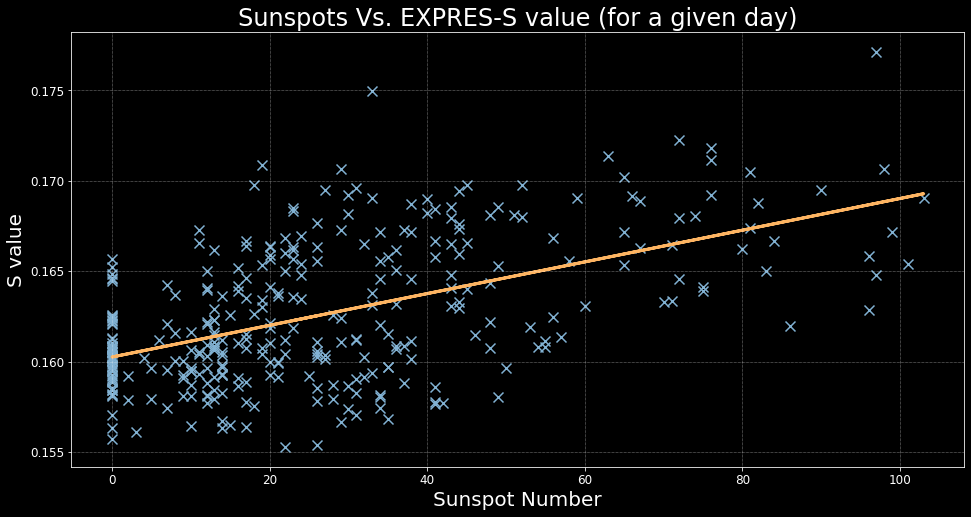

In [7]:
time1 = SN_daily.index
data1 = np.array(SN_daily)
time2 = s_values.index
data2 = np.array(s_values)

df1 = pd.DataFrame(zip(time1, data1), columns=('time', 'sunspots'))
df2 = pd.DataFrame(zip(time2, data2), columns=('time', 's_values'))
df = df1.merge(df2, how='outer', on='time', sort='time').dropna()

df.plot(figsize=(16, 8), kind='scatter', x='sunspots', y='s_values', marker='x', s=100, c="C4")
x = df["sunspots"]
y = df["s_values"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, np.poly1d(fit)(x), lw=3, c="C5", zorder=1)
plt.title("Sunspots Vs. EXPRES-S value (for a given day)")
plt.xlabel("Sunspot Number")
plt.ylabel("S value")

## comparison over time

SN Source: WDC-SILSO, Royal Observatory of Belgium, Brussels


Text(0.5, 1.0, 'Daily EXPRES-S Value')

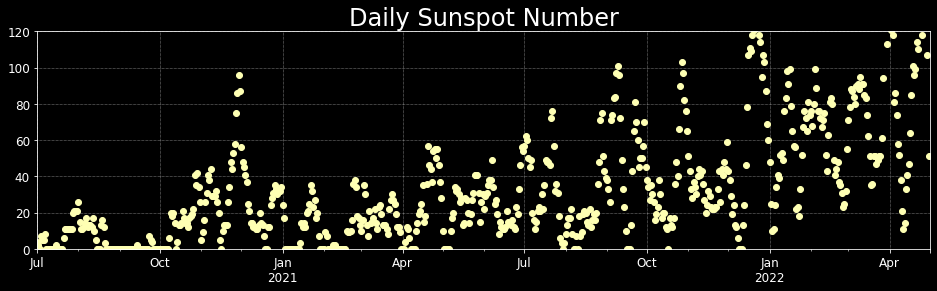

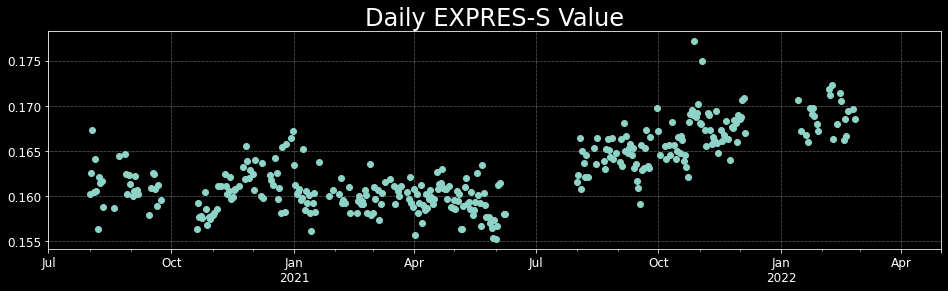

In [9]:
plt.figure(figsize=(16, 4))
SN_daily.plot(linestyle='None', marker='o', c='C1')
plt.xlim(date_range[0], date_range[-1]); 
plt.ylim(0, 120); 
plt.title(f"Daily Sunspot Number")
print("SN Source: WDC-SILSO, Royal Observatory of Belgium, Brussels")

plt.figure(figsize=(16, 4))
s_values.plot(linestyle='None', marker='o', c='C0')
plt.xlim(date_range[0], date_range[-1]);
plt.title("Daily EXPRES-S Value")

## Lomb-Scargle Periodograms

Finding optimal frequency:
 - Estimated peak width = 0.00941
 - Using 5 steps per peak; omega_step = 0.00188
 - User-specified period range:  5 to 35
 - Computing periods at 574 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Sunspots best period: 0.9374118119212855 Carrington rotations
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  5 to 35
 - Computing periods at 493 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
EXPRES-S best period: 1.010923885733531 Carrington rotations


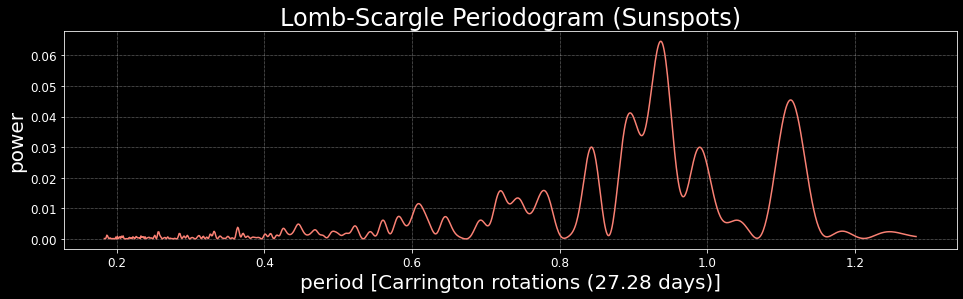

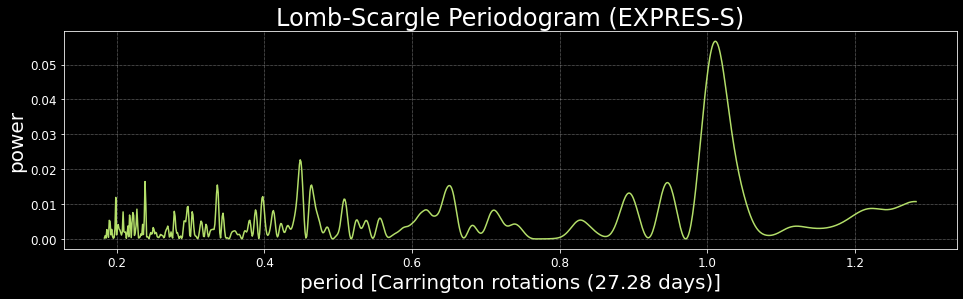

In [10]:
t = np.array(range(len(SN_daily)))
y = np.array(SN_daily)
not_na = ~np.isnan(y)
t = t[not_na]
y = y[not_na]

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.period_range = (5, 35)
model.fit(t, y)

periods = np.linspace(5, 35, 1000)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

plt.figure(figsize=(16, 4))
plt.plot(periods/27.28, scores, c="C3")
plt.title("Lomb-Scargle Periodogram (Sunspots)")
plt.xlabel("period [Carrington rotations (27.28 days)]")
plt.ylabel("power")

print(f"Sunspots best period: {model.best_period/27.28} Carrington rotations")

t = np.array(range(len(s_values)))
y = np.array(s_values, dtype="float64")
not_na = ~np.isnan(y)
t = t[not_na]
y = y[not_na]

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.period_range = (5, 35)
model.fit(t, y)

periods = np.linspace(5, 35, 1000)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
    
plt.figure(figsize=(16, 4))
plt.plot(periods/27.28, scores, c="C6")
plt.title("Lomb-Scargle Periodogram (EXPRES-S)")
plt.xlabel("period [Carrington rotations (27.28 days)]")
plt.ylabel("power")

print(f"EXPRES-S best period: {model.best_period/27.28} Carrington rotations")

## sanity check

Finding optimal frequency:
 - Estimated peak width = 8.42e-05
 - Using 5 steps per peak; omega_step = 1.68e-05
 - User-specified period range:  5 to 35
 - Computing periods at 63963 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
best period: 1.0022788489345302 Carrington rotations


Text(0, 0.5, 'power')

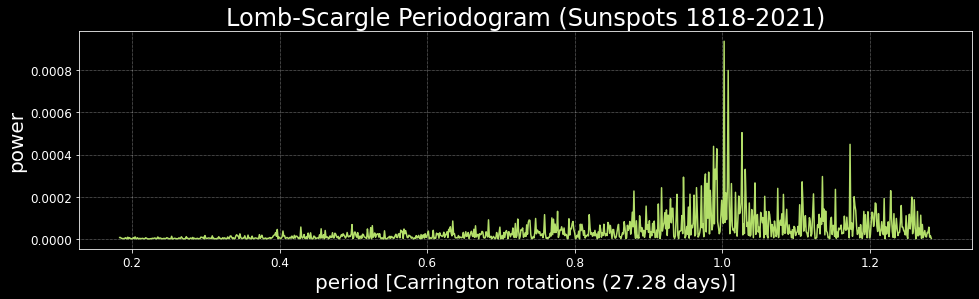

In [11]:
t = np.array(range(len(SN_record)))
y = np.array(SN_record)
not_na = ~np.isnan(y)
t = t[not_na]
y = y[not_na]

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.period_range = (5, 35)
model.fit(t, y)
periods = np.linspace(5, 35, 1000)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
    
plt.figure(figsize=(16, 4))
plt.plot(periods/27.28, scores, c="C6")
print(f"best period: {model.best_period/27.28} Carrington rotations")
plt.title("Lomb-Scargle Periodogram (Sunspots 1818-2021)")
plt.xlabel("period [Carrington rotations (27.28 days)]")
plt.ylabel("power")

Finding optimal frequency:
 - Estimated peak width = 8.42e-05
 - Using 5 steps per peak; omega_step = 1.68e-05
 - User-specified period range:  2.5e+03 to 5.1e+03
 - Computing periods at 75 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
best period: 10.872357825723759 years


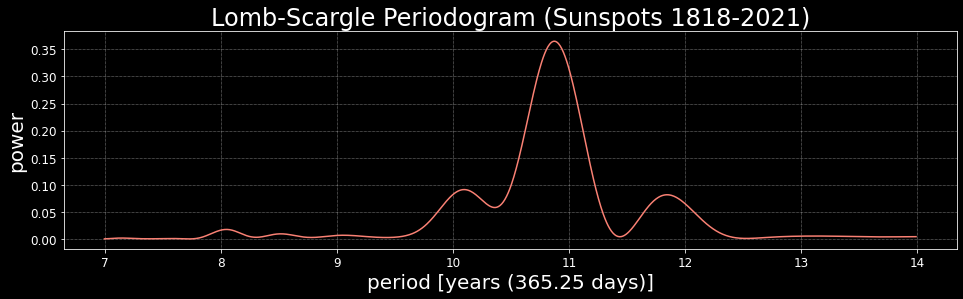

In [12]:
t = np.array(range(len(SN_record)))
y = np.array(SN_record)
not_na = ~np.isnan(y)
t = t[not_na]
y = y[not_na]

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.period_range = (365*7, 365*14)
model.fit(t, y)

periods = np.linspace(365*7, 365*14, 1000)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
    
plt.figure(figsize=(16, 4))
plt.plot(periods/365.25, scores, c="C3")
plt.title("Lomb-Scargle Periodogram (Sunspots 1818-2021)")
plt.xlabel("period [years (365.25 days)]")
plt.ylabel("power")

print(f"best period: {model.best_period/365.25} years")

Text(0.5, 1.0, 'Sunspot Numbers and Best Fit Sinusoidal Period')

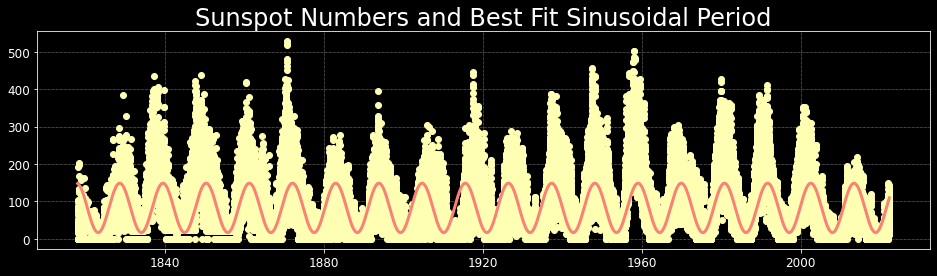

In [13]:
dates = SN_record.index[not_na]

plt.figure(figsize=(16, 4))
plt.plot(dates, y, linestyle='None', marker='o', c="C1")
sinfit = model.predict(t)
plt.plot(dates, sinfit, lw=3, c='C3')
plt.title("Sunspot Numbers and Best Fit Sinusoidal Period")